In [1]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn import model_selection
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import plotly.graph_objs as go




# Settando configurações padrão para todos os modelos

In [2]:
df = pd.read_csv(os.getcwd() + '/DATABASE/base-reduzida-v5.csv', sep = ',')
df = df.drop(df.columns[0], axis=1)
df.head()

Estado de saúde  Pouco Interesse em atividades  \
0              1.0                            1.0   
1              1.0                            1.0   
2              1.0                            1.0   
3              1.0                            1.0   
4              1.0                            1.0   

   Frequência de consumo de bebida  Qtde dias na semana que bebe  \
0                              2.0                           0.0   
1                              1.0                           0.0   
2                              2.0                           0.0   
3                              2.0                           0.0   
4                              1.0                           0.0   

   Qtde doses quando bebe  Aviso bebida últimos 12M  \
0                     3.0                       1.0   
1                     0.0                       0.0   
2                     2.0                       1.0   
3                     4.0                       1.0   
4                     0.0                       0.0   

   Falta de memória após beber nos últimos 12M  \
0                                          1.0   
1                                          0.0   
2                                          1.0   
3                                          1.0   
4                                          0.0   

   Mais de 5 doses em uma ocasião nos últimos 30D  Problemas com cansaço  \
0                                             2.0                    1.0   
1                                             0.0                    1.0   
2                                             2.0                    1.0   
3                                             2.0                    1.0   
4                                             0.0                    1.0   

   Problemas para dormir  Sentimento depressivo  Sentimento de fracasso  \
0                    1.0                    1.0                     1.0   
1                    1.0                    1.0                     1.0   
2                    1.0                    1.0                     1.0   
3                    1.0                    1.0                     1.0   
4                    1.0                    1.0                     1.0   

   Ideação suicida  Diagnóstico de depressão  Diagnóstico de alcoolismo  \
0              1.0                       0.0                        0.0   
1              1.0                       0.0                        0.0   
2              1.0                       0.0                        0.0   
3              1.0                       0.0                        0.0   
4              1.0                       0.0                        0.0   

   Alcoolismo e Depressão  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

In [3]:
seed = 101 # Para que a separação dos dados ocorra sempre a partir da mesma semente (seed), e seja reproduzível em qualquer execução

In [4]:
#Randomizando os dados do Dataframe
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [5]:
X = df.drop(columns=["Alcoolismo e Depressão", "Diagnóstico de depressão", "Diagnóstico de alcoolismo"], axis=1)
Y = df["Diagnóstico de depressão"]


print("X:", len(X), "Y:", len(Y))

X: 16779 Y: 16779


In [6]:
test_size = 0.4 # Tamanho do conjunto de teste

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = test_size, random_state=seed, stratify=Y)

In [7]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)

In [8]:
# Ajustar o MinMaxScaler aos dados de treinamento
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [9]:
cor_coral = (.4, .6, .8, .5)

## Funções Reutilizáveis

In [10]:
# Cores personalizadas
colors = ['#2D4762', '#47709A', '#9DB8D2', '#D5E0EC']

### Matriz de Confusão

In [11]:
def ConfusionMatrix(ConfusionMatrix_algoritm, Accuracy) :
# Calculando a acurácia para valores negativos (True Negative Rate)
   tn_rate_ada = ConfusionMatrix_algoritm[0, 0] / ConfusionMatrix_algoritm[0].sum()

   # Calculando a acurácia para valores positivos (True Positive Rate)
   tp_rate_ada = ConfusionMatrix_algoritm[1, 1] / ConfusionMatrix_algoritm[1].sum()

   # Plotando a matriz de confusão como um heatmap
   plt.figure(figsize=(10, 8))
   sns.heatmap(ConfusionMatrix_algoritm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])


   # Adicionando texto para acurácia - ajustando a posição e a cor de fundo
   plt.text(1, -0.3, f'Acurácia Geral do modelo:  {Accuracy:.2%}', ha='center', fontsize=12, backgroundcolor='white')
   plt.text(1, -0.2, f'Acurácia do modelo para valores Negativos: {tn_rate_ada:.2%}', ha='center', fontsize=12, backgroundcolor='white')
   plt.text(1, -0.1, f'Acurácia do modelo para valores Positivos: {tp_rate_ada:.2%}', ha='center', fontsize=12, backgroundcolor='white')


   # Ajustando o layout
   plt.tight_layout()

   # Exibindo o gráfico
   plt.show()

### Curva de Aprendizado

In [12]:
# Definindo a função plot_learning_curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 8))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Número de exemplos de treinamento")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color=colors[0])
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color=colors[2])
    axes.plot(train_sizes, train_scores_mean, 'o-', color=colors[0],
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color=colors[2],
              label="Cross-validation score")

    axes.legend(loc="best")

## Modelo de Regressão Logística

In [13]:
# Inicializando o modelo de regressão logística
RegLog = LogisticRegression()

# Treinando o modelo com o conjunto de dados de treinamento
RegLog.fit(X_train_scaled, y_train_smote)

# Realizando previsões com o conjunto de dados de teste
Y_predRegLog = RegLog.predict(X_test_scaled)

# Avaliando o modelo
accuracy_rl = accuracy_score(Y_test, Y_predRegLog)
conf_matrix_rl = confusion_matrix(Y_test, Y_predRegLog)
class_report_rl = classification_report(Y_test, Y_predRegLog)
precision_rl = precision_score(Y_test, Y_predRegLog)
recall_rl = recall_score(Y_test, Y_predRegLog)
f1_rl = f1_score(Y_test, Y_predRegLog)



# Exibindo os resultados
print(f"Acurácia geral do modelo: {accuracy_rl:.2%}")
print('Matriz de confusão:\n', conf_matrix_rl)
print('Relatório de classificação:\n', class_report_rl)




Acurácia geral do modelo: 97.68%
Matriz de confusão:
 [[3378    1]
 [ 155 3178]]
Relatório de classificação:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3379
         1.0       1.00      0.95      0.98      3333

    accuracy                           0.98      6712
   macro avg       0.98      0.98      0.98      6712
weighted avg       0.98      0.98      0.98      6712



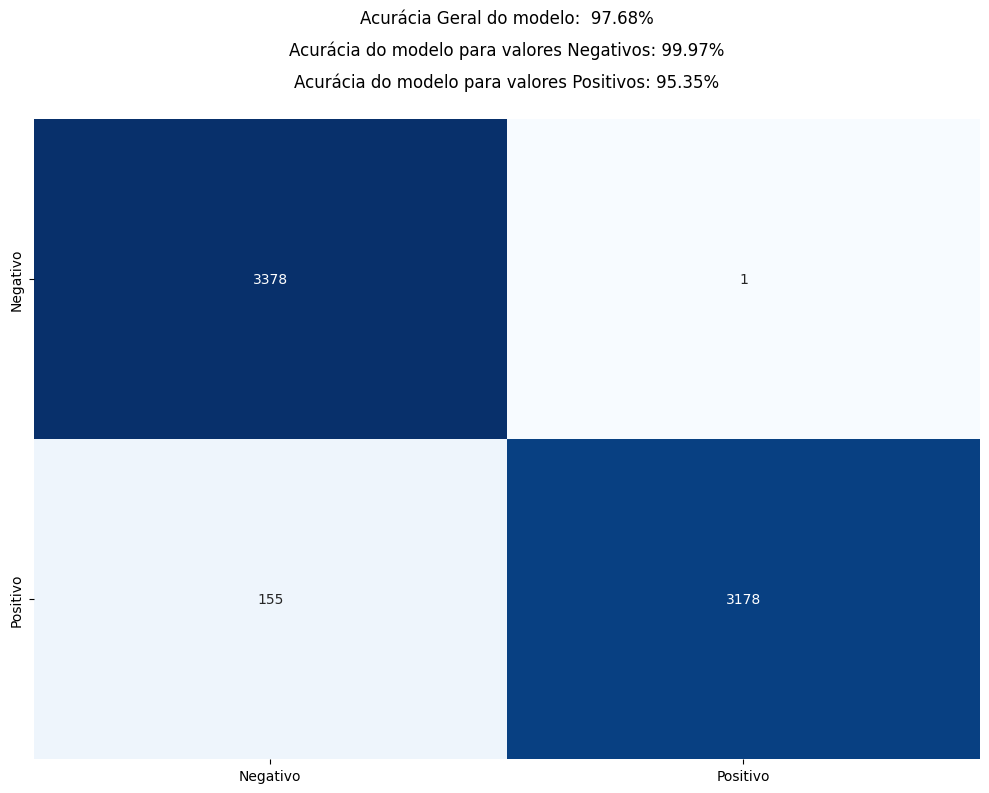

In [14]:
ConfusionMatrix(conf_matrix_rl,accuracy_rl)

## K-Nearest Neighbors (K-NN)

O melhor valor de k é 5 com uma acurácia de 0.96


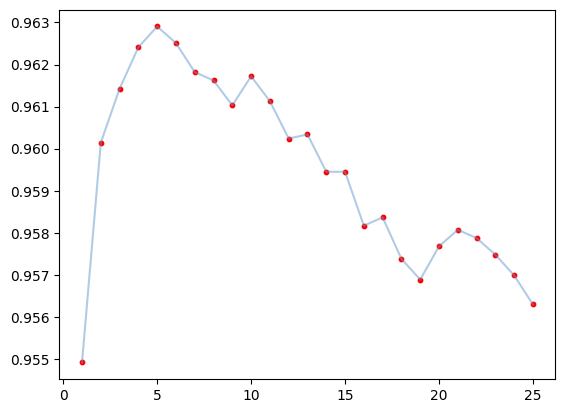

In [15]:

k_values = range(1, 26)
mean_scores = []

# Loop para calcular a acurácia para cada valor de k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train_smote, cv=10, scoring='accuracy')  # Usando validação cruzada
    mean_scores.append(scores.mean())

# Definindo a cor coral com transparência
cor_coral = (.4, .6, .8, .5)

# Plotar o gráfico de acurácia com a cor coral
plt.plot(k_values, mean_scores, color=cor_coral)

# Adicionar bolinhas vermelhas para cada ponto com tamanho reduzido
plt.scatter(k_values, mean_scores, color='red', s=10)  # Ajuste o tamanho com o parâmetro 's'



# Mostrar o melhor valor de k
optimal_k = k_values[mean_scores.index(max(mean_scores))]
print(f"O melhor valor de k é {optimal_k} com uma acurácia de {max(mean_scores):.2f}")

# Exibir o gráfico
plt.show()


In [16]:
# Inicializar e treinar o K-NN
k = optimal_k  # É o melhor valor encontrado
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train_smote)

# Fazer previsões
Y_pred_knn = knn.predict(X_test_scaled)

# Avaliar o modelo

accuracy_knn  = accuracy_score(Y_test, Y_pred_knn )
confusion_matrix_knn  = confusion_matrix(Y_test, Y_pred_knn )
classification_report_knn  = classification_report(Y_test, Y_pred_knn )
precision_knn = precision_score(Y_test, Y_pred_knn)
recall_knn = recall_score(Y_test, Y_pred_knn)
f1_knn = f1_score(Y_test, Y_pred_knn)



# Exibindo os resultados
print(f"Acurácia geral do modelo: {accuracy_knn:.2%}")
print('Matriz de confusão:\n', confusion_matrix_knn)
print('Relatório de classificação:\n', classification_report_knn)

Acurácia geral do modelo: 96.54%
Matriz de confusão:
 [[3331   48]
 [ 184 3149]]
Relatório de classificação:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      3379
         1.0       0.98      0.94      0.96      3333

    accuracy                           0.97      6712
   macro avg       0.97      0.97      0.97      6712
weighted avg       0.97      0.97      0.97      6712



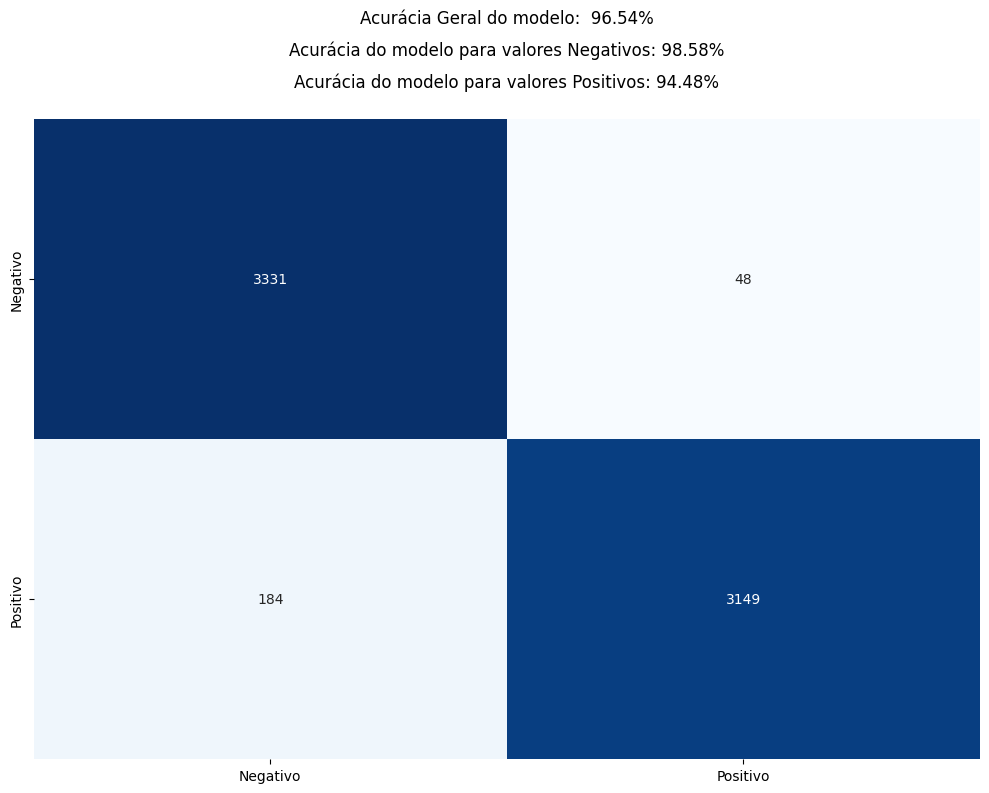

In [17]:
ConfusionMatrix(confusion_matrix_knn, accuracy_knn)

## Classificador Random Florest 

Acurácia geral do modelo: 97.63%
Matriz de confusão (Random Forest):
 [[3368   11]
 [ 148 3185]]
Relatório de classificação (Random Forest):
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3379
         1.0       1.00      0.96      0.98      3333

    accuracy                           0.98      6712
   macro avg       0.98      0.98      0.98      6712
weighted avg       0.98      0.98      0.98      6712



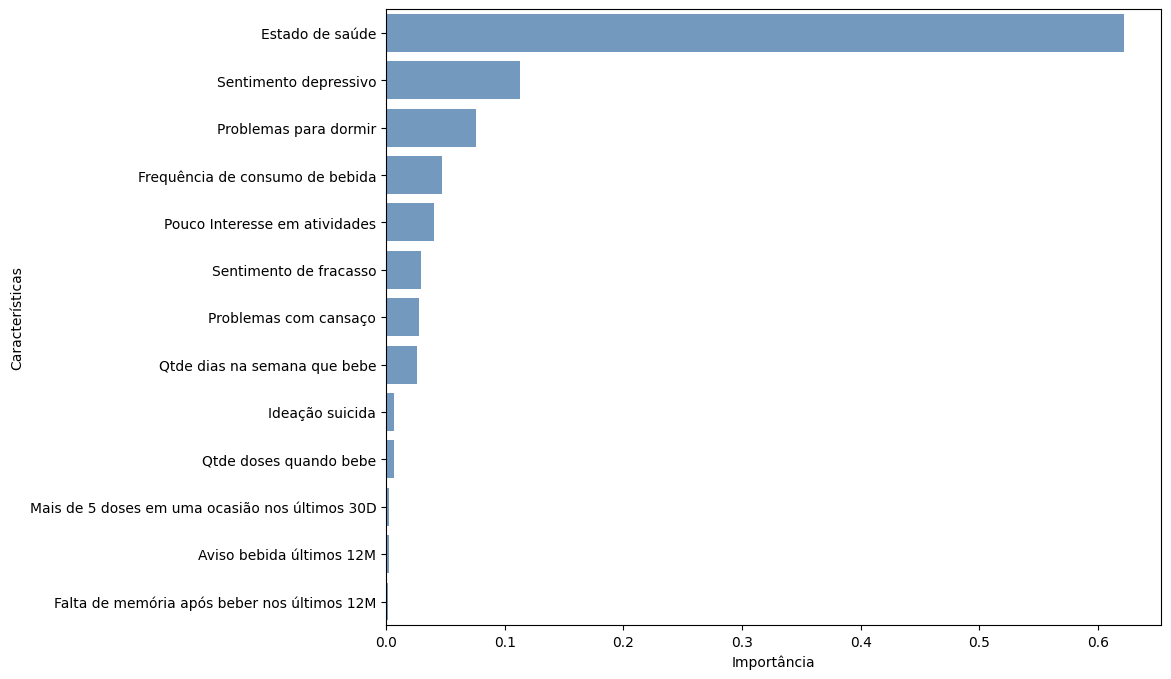

In [18]:
# Inicializando o modelo Random Forest com o número desejado de árvores
# n_estimators é o número de árvores na floresta
rf = RandomForestClassifier(n_estimators=1000, random_state=seed)

# Treinando o modelo com os dados de treinamento
rf.fit(X_train_scaled, y_train_smote)

# Fazendo previsões no conjunto de teste
Y_pred_rf = rf.predict(X_test_scaled)

# Avaliar o modelo
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
classification_report_rf = classification_report(Y_test, Y_pred_rf)
precision_rf = precision_score(Y_test, Y_pred_rf)
recall_rf = recall_score(Y_test, Y_pred_rf)
f1_rf = f1_score(Y_test, Y_pred_rf)

# Imprimindo os resultados
print(f"Acurácia geral do modelo: {accuracy_rf:.2%}")
print(f'Matriz de confusão (Random Forest):\n {confusion_matrix_rf}')
print(f'Relatório de classificação (Random Forest):\n {classification_report_rf}')


# Obtendo as importâncias das características
feature_importances_rf = rf.feature_importances_

# Convertendo as importâncias em um DataFrame para facilitar a visualização
features_df = pd.DataFrame({'Características': X.columns, 'Importância': feature_importances_rf})

# Ordenando os dados pela importância
features_df = features_df.sort_values(by='Importância', ascending=False)

# Visualização gráfica
plt.figure(figsize=(10, 8))
sns.barplot(x='Importância', y='Características', data=features_df, color=cor_coral)
plt.show()



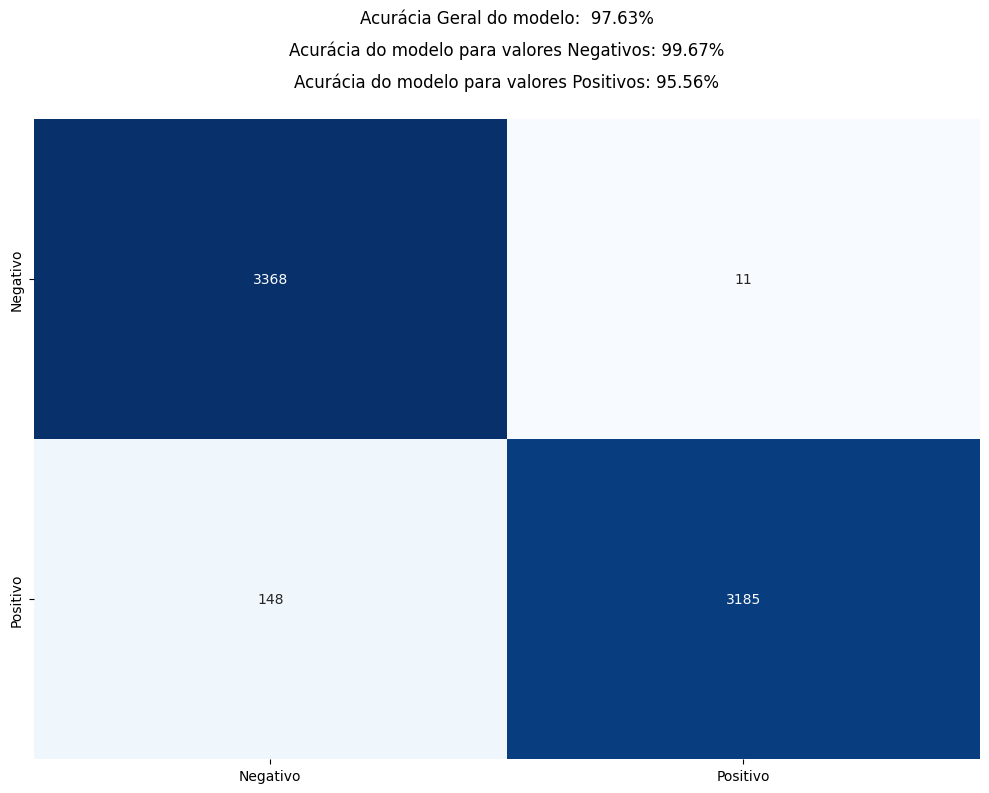

In [19]:
ConfusionMatrix(confusion_matrix_rf, accuracy_rf)

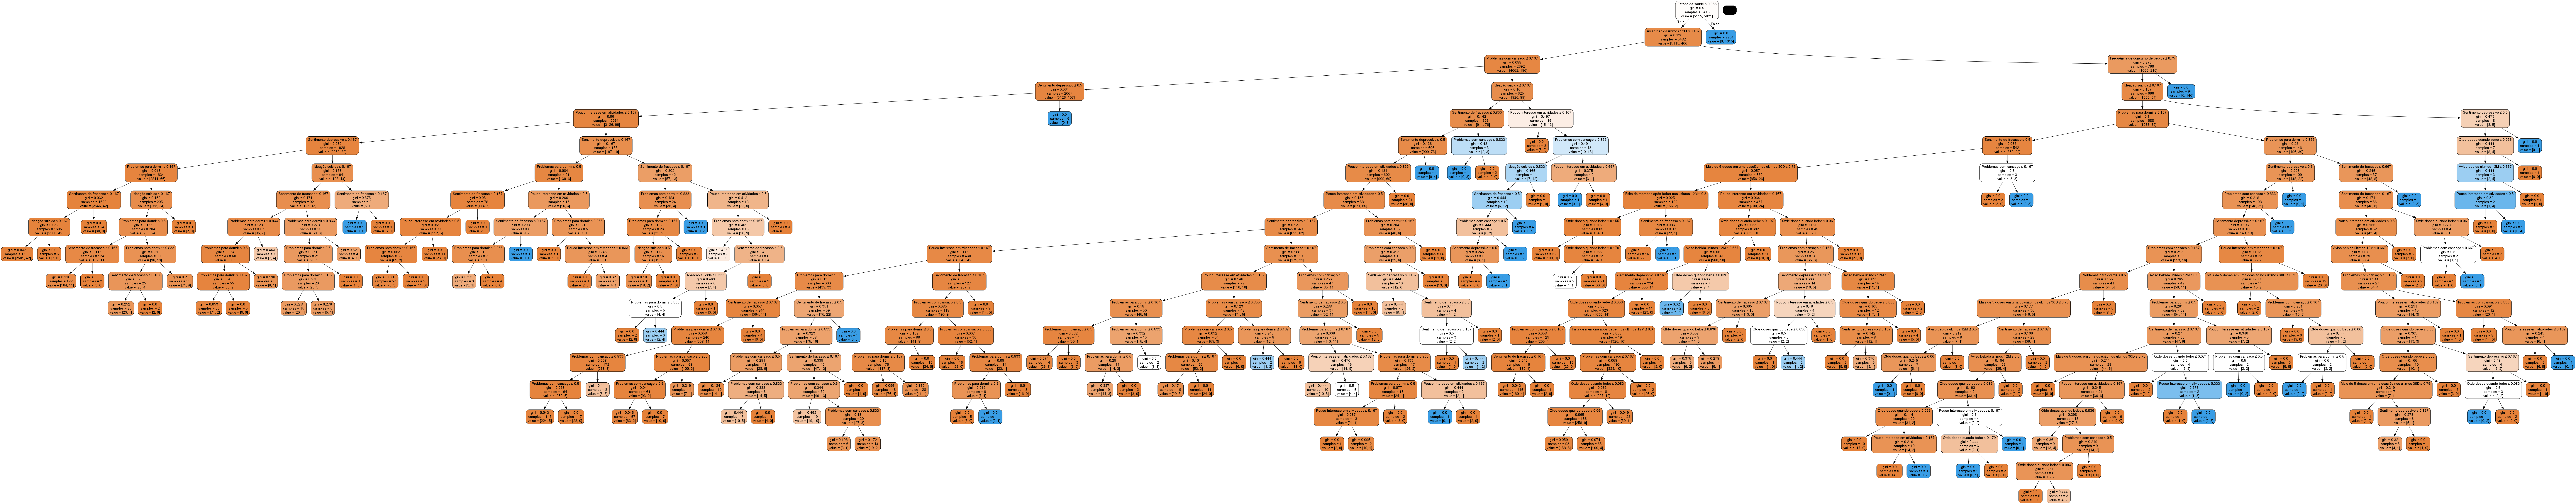

In [20]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import os

# Escolha a árvore que você gostaria de visualizar.
# Por exemplo, se você quiser visualizar a primeira árvore, você pode fazer:
single_tree = rf.estimators_[0]

# Exporta a imagem da árvore para um array de bytes
dot_data = tree.export_graphviz(single_tree, out_file=None, 
                                feature_names=X_train.columns,
                                filled=True, rounded=True,
                                special_characters=True)

# Use o pydotplus para converter o que foi exportado em um gráfico
graph = pydotplus.graph_from_dot_data(dot_data)

# Mostre a imagem
Image(graph.create_png())


## ADABOOST

Acurácia geral do modelo: 97.77%
Matriz de confusão (AdaBoost):
 [[3379    0]
 [ 150 3183]]
Relatório de classificação (AdaBoost):
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3379
         1.0       1.00      0.95      0.98      3333

    accuracy                           0.98      6712
   macro avg       0.98      0.98      0.98      6712
weighted avg       0.98      0.98      0.98      6712



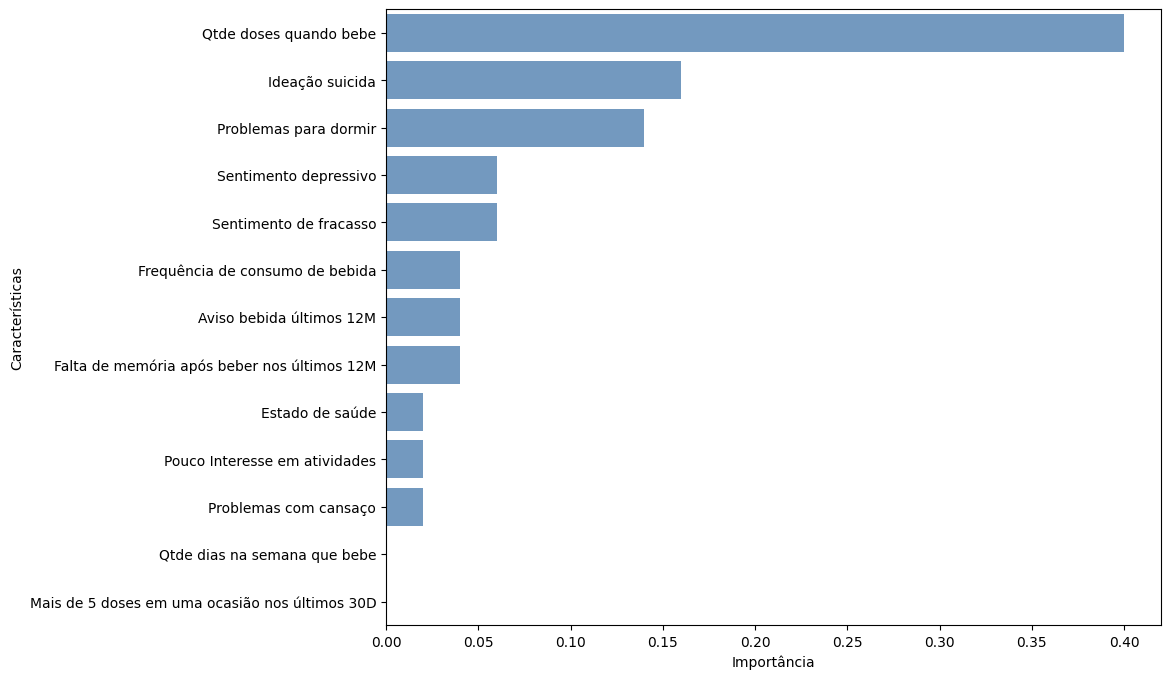

In [21]:
# Escolhendo um classificador base. Por padrão, o AdaBoost usa um DecisionTreeClassifier com max_depth=1
base_clf = DecisionTreeClassifier(max_depth=1)

# Instanciando o AdaBoost com o classificador base
# Você pode ajustar o número de estimadores (n_estimators) e a taxa de aprendizagem (learning_rate)
ada_clf = AdaBoostClassifier(estimator=base_clf, n_estimators=50, learning_rate=1, random_state=seed)

# Treinando o modelo AdaBoost com os dados de treinamento escalonados
ada_clf.fit(X_train_scaled, y_train_smote)

# Fazendo previsões com os dados de teste
Y_pred_ada = ada_clf.predict(X_test_scaled)
cor_coral = (.4, .6, .8, .5)



# Avaliar o modelo
accuracy_ada= accuracy_score(Y_test, Y_pred_ada)
confusion_matrix_ada= confusion_matrix(Y_test, Y_pred_ada)
classification_report_ada= classification_report(Y_test, Y_pred_ada)
precision_ada = precision_score(Y_test, Y_pred_ada)
recall_ada = recall_score(Y_test, Y_pred_ada)
f1_ada = f1_score(Y_test, Y_pred_ada)

# Imprimindo os resultados
print(f"Acurácia geral do modelo: {accuracy_ada:.2%}")
print(f'Matriz de confusão (AdaBoost):\n {confusion_matrix_ada}')
print(f'Relatório de classificação (AdaBoost):\n {classification_report_ada}')


# Treinando o modelo AdaBoost com os dados de treinamento escalonados
ada_clf.fit(X_train_scaled, y_train_smote)

# Obtendo as importâncias das características
feature_importances_ada = ada_clf.feature_importances_

# Convertendo as importâncias em um DataFrame para facilitar a visualização
features_df = pd.DataFrame({'Características': X.columns, 'Importância': feature_importances_ada})

# Ordenando os dados pela importância
features_df = features_df.sort_values(by='Importância', ascending=False)

# Visualização gráfica
plt.figure(figsize=(10, 8))
sns.barplot(x='Importância', y='Características', data=features_df, color=cor_coral)
plt.show()



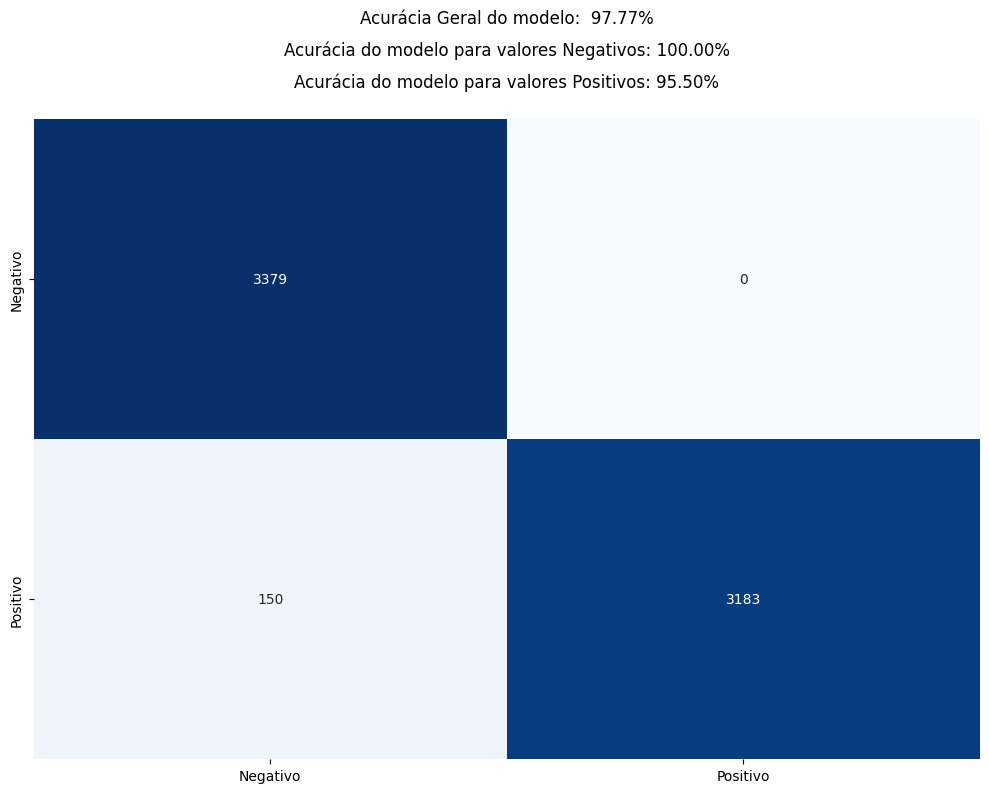

In [22]:
ConfusionMatrix(confusion_matrix_ada, accuracy_ada)

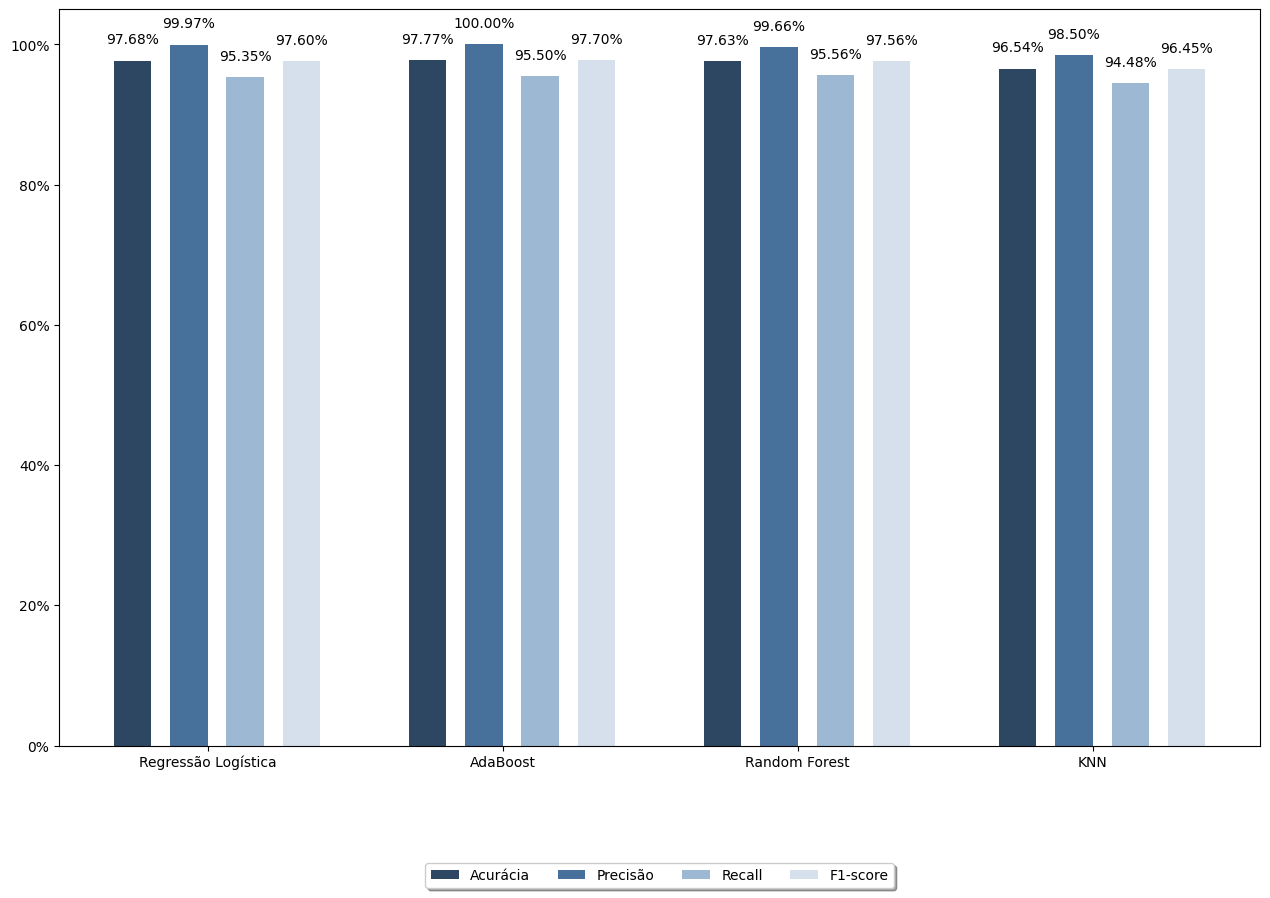

In [23]:


# Substitua estes com os valores reais das suas métricas
accuracy_scores = [accuracy_rl, accuracy_ada, accuracy_rf, accuracy_knn]
precision_scores = [precision_rl, precision_ada, precision_rf, precision_knn]
recall_scores = [recall_rl, recall_ada, recall_rf, recall_knn]
f1_scores = [f1_rl, f1_ada, f1_rf, f1_knn]
# print(accuracy_scores)
# print(precision_scores)
# print(recall_scores)
# print(f1_scores)


# Nomes dos modelos
models = ['Regressão Logística', 'AdaBoost', 'Random Forest', 'KNN']

# Configurações do gráfico
n_groups = len(models)
index = np.arange(n_groups) * 5.5  # Aumenta o espaço entre os grupos
bar_width = 0.7



# Criar figura e eixo
fig, ax = plt.subplots()

# Adicionar barras para cada métrica
accuracy_bars = ax.bar(index - bar_width * 2, accuracy_scores, bar_width, label='Acurácia', color=colors[0])
precision_bars = ax.bar(index - bar_width / 2, precision_scores, bar_width, label='Precisão', color=colors[1])
recall_bars = ax.bar(index + bar_width / 1.0, recall_scores, bar_width, label='Recall', color=colors[2])
f1_bars = ax.bar(index + bar_width * 2.5 , f1_scores, bar_width, label='F1-score', color=colors[3])

# Adicionar rótulos, título e legendas
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=4)

# Formatar o eixo y para mostrar porcentagem
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Função para adicionar rótulos de valor em cada barra
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 10),  # Aumenta o deslocamento vertical para evitar sobreposição
                    textcoords="offset points",
                    ha='center', va='bottom')

# Chamar a função para adicionar rótulos em todas as barras
add_value_labels(accuracy_bars)
add_value_labels(precision_bars)
add_value_labels(recall_bars)
add_value_labels(f1_bars)

# Ajuste do layout para acomodar a legenda
plt.tight_layout(rect=[0, 0.2, 2, 2])

# Mostrar o gráfico
plt.show()

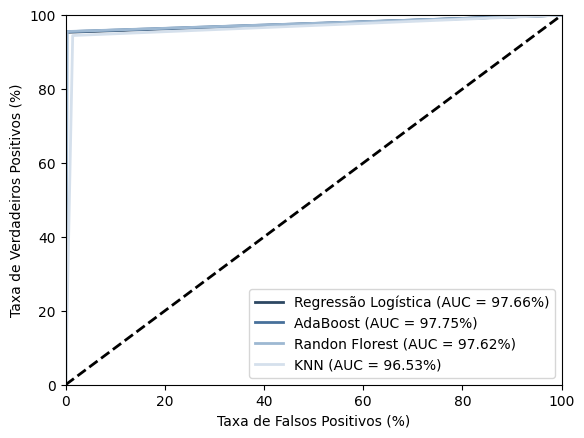

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Suponha que você tenha os valores verdadeiros e os scores previstos para cada modelo
y_true = Y_test  # rótulos verdadeiros
y_score_model1 = Y_predRegLog  # scores do modelo 1
y_score_model2 = Y_pred_ada  # scores do modelo 2
y_score_model3 = Y_pred_rf  # scores do modelo 3
y_score_model4 = Y_pred_knn # scores do modelo 3

# Calcular FPR, TPR e AUC para cada modelo
fpr1, tpr1, _ = roc_curve(y_true, y_score_model1)
fpr2, tpr2, _ = roc_curve(y_true, y_score_model2)
fpr3, tpr3, _ = roc_curve(y_true, y_score_model3)
fpr4, tpr4, _ = roc_curve(y_true, y_score_model4)

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
auc4 = auc(fpr4, tpr4)

# Converter as taxas para porcentagem
fpr1, tpr1 = fpr1 * 100, tpr1 * 100
fpr2, tpr2 = fpr2 * 100, tpr2 * 100
fpr3, tpr3 = fpr3 * 100, tpr3 * 100
fpr4, tpr4 = fpr4 * 100, tpr4 * 100

colors = ['#2D4762', '#47709A', '#9DB8D2', '#D5E0EC']


# Criar a figura
plt.figure()

# Plotar a curva ROC para cada modelo em porcentagem
plt.plot(fpr1, tpr1, color=colors[0], lw=2, label='Regressão Logística (AUC = %0.2f%%)' % (auc1 * 100))
plt.plot(fpr2, tpr2, color=colors[1], lw=2, label='AdaBoost (AUC = %0.2f%%)' % (auc2 * 100))
plt.plot(fpr3, tpr3, color=colors[2], lw=2, label='Randon Florest (AUC = %0.2f%%)' % (auc3 * 100))
plt.plot(fpr4, tpr4, color=colors[3], lw=2, label='KNN (AUC = %0.2f%%)' % (auc4 * 100))

# Plotar a linha de não-discriminação
plt.plot([0, 100], [0, 100], color='black', lw=2, linestyle='--')

# Adicionar rótulos e título
plt.xlim([0.0, 100.0])
plt.ylim([0.0, 100.0])
plt.xlabel('Taxa de Falsos Positivos (%)')
plt.ylabel('Taxa de Verdadeiros Positivos (%)')
plt.legend(loc="lower right")

# Mostrar o gráfico
plt.show()





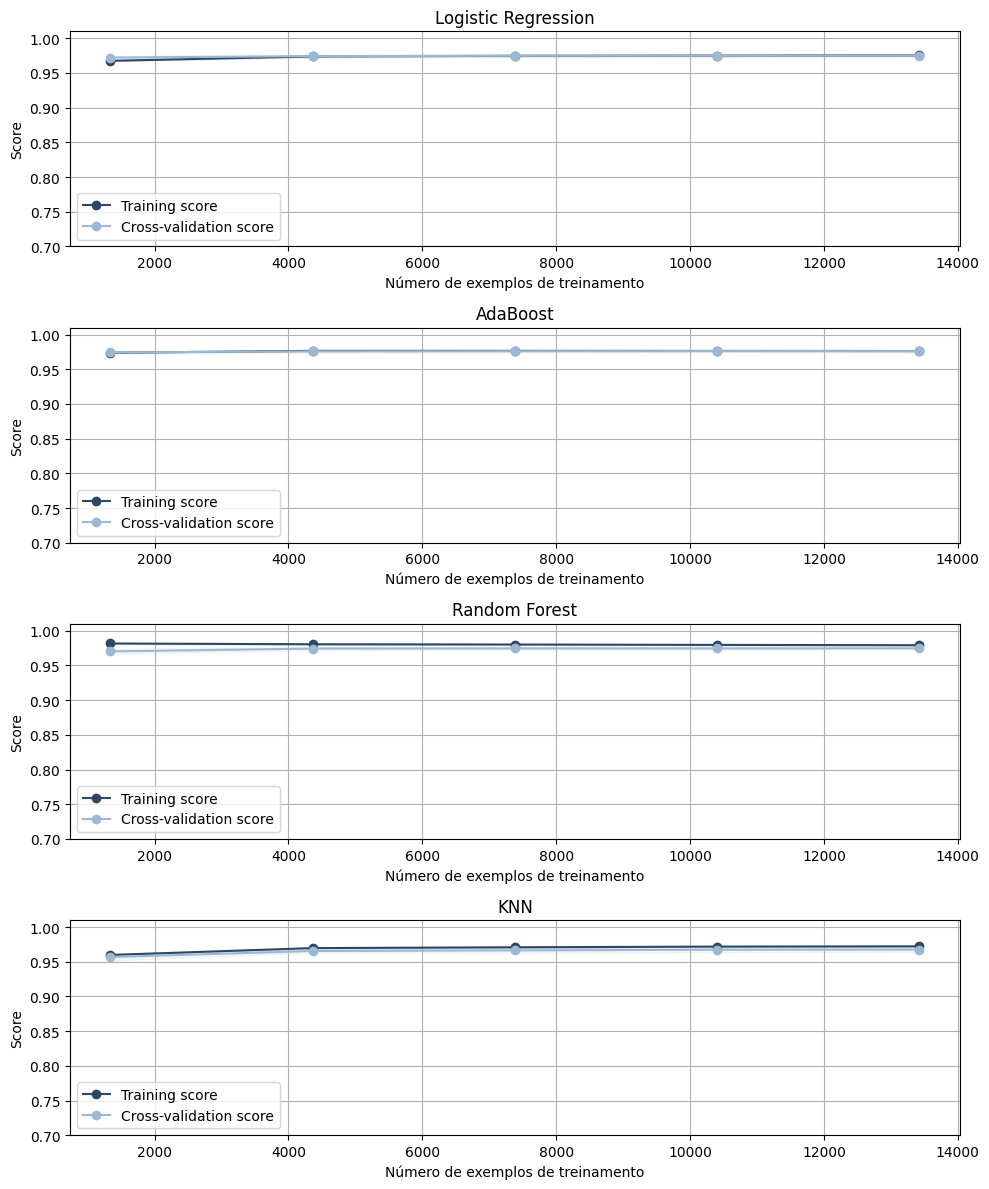

In [25]:
# Criando subplots para os gráficos
fig, axes = plt.subplots(4, 1, figsize=(10, 12))


# Plot learning curve para Logistic Regression
plot_learning_curve(RegLog, "Logistic Regression", X, Y, axes=axes[0], ylim=(0.7, 1.01), cv=5, n_jobs=4)

# Plot Curva de Aprendizado para AdaBoost
plot_learning_curve(ada_clf, "AdaBoost", X, Y, axes=axes[1], ylim=(0.7, 1.01), cv=5, n_jobs=4)

# Plot Curva de Aprendizado para Random Forest
plot_learning_curve(rf, "Random Forest", X, Y, axes=axes[2], ylim=(0.7, 1.01), cv=5, n_jobs=4)

# Plot Curva de Aprendizado para KNN
plot_learning_curve(knn, "KNN", X, Y, axes=axes[3], ylim=(0.7, 1.01), cv=5, n_jobs=4)

plt.tight_layout()
plt.show()


# Associando erros com o diagnóstico de Alcoolismo


In [26]:
def DepressaoComAlcoolismo(y_pred):   
   # Convertendo Y_predRegLog para uma Series do Pandas com o mesmo índice que X_test e Y_test para sincronização
   y_pred_log = pd.Series(y_pred, index=Y_test.index)

   # Filtrando os casos de alcoolismo no conjunto de teste
   casos_alcoolismo_teste = df.loc[X_test.index][df['Diagnóstico de alcoolismo'] == 1.0]

   # Agora, compare suas previsões com os verdadeiros rótulos nesses casos de alcoolismo
   acertos_alcoolismo = y_pred_log[casos_alcoolismo_teste.index] == Y_test[casos_alcoolismo_teste.index]

   # Calcule a proporção de acertos em casos de alcoolismo
   proporcao_acertos_alcoolismo = acertos_alcoolismo.sum() / len(casos_alcoolismo_teste)
   
   print(f"A proporção de acertos do algoritmo em casos com diagnóstico de alcoolismo é: {proporcao_acertos_alcoolismo:.2%}")


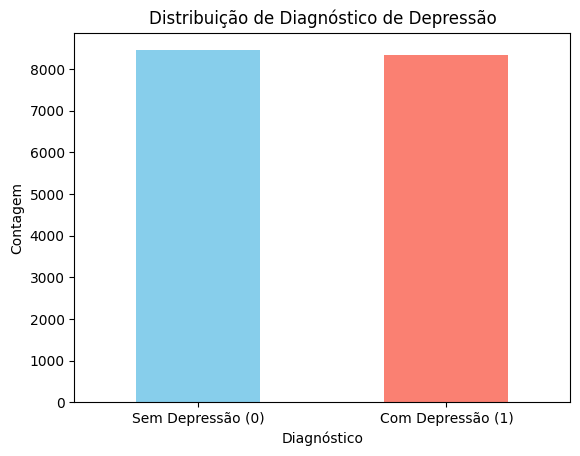

In [27]:
import matplotlib.pyplot as plt

# Balanceamento da variável alvo
df["Diagnóstico de depressão"].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição de Diagnóstico de Depressão')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Sem Depressão (0)', 'Com Depressão (1)'], rotation=0)
plt.show()


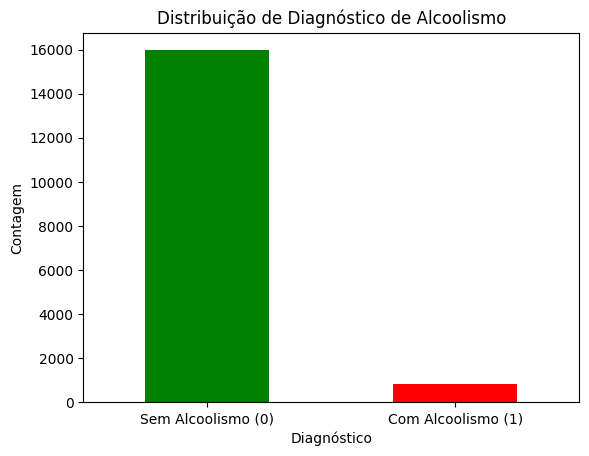

In [28]:
# Distribuição de diagnóstico de alcoolismo
df["Diagnóstico de alcoolismo"].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribuição de Diagnóstico de Alcoolismo')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Sem Alcoolismo (0)', 'Com Alcoolismo (1)'], rotation=0)
plt.show()


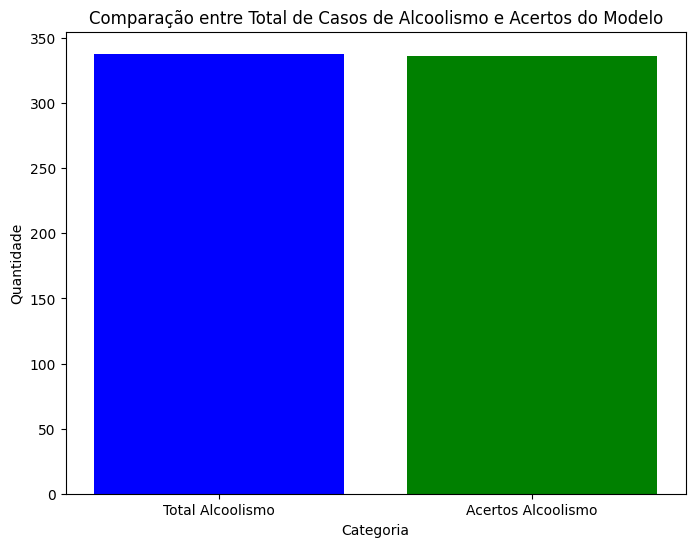

In [29]:
# Supondo que Y_pred é a predição do seu modelo e Y_test são os valores reais
acertos_depressao = (Y_predRegLog == Y_test)
df_alcoolismo = df.loc[Y_test.index, "Diagnóstico de alcoolismo"]

# Total de casos de alcoolismo no conjunto de teste
total_casos_alcoolismo = df_alcoolismo.sum()

# Filtrar os casos corretamente previstos para alcoolismo
acertos_alcoolismo = (Y_predRegLog[df_alcoolismo == 1] == Y_test[df_alcoolismo == 1]).sum()

# Agora vamos criar o gráfico
import matplotlib.pyplot as plt

# Os dados
categorias = ['Total Alcoolismo', 'Acertos Alcoolismo']
valores = [total_casos_alcoolismo, acertos_alcoolismo]

# Criação do gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(categorias, valores, color=['blue', 'green'])
plt.xlabel('Categoria')
plt.ylabel('Quantidade')
plt.title('Comparação entre Total de Casos de Alcoolismo e Acertos do Modelo')
plt.show()


In [30]:


def GraficoDeRosca(y_pred, name):
    # Supondo que Y_pred é a predição do seu modelo e Y_test são os valores reais
    acertos_depressao = (y_pred == Y_test)
    df_alcoolismo = df.loc[Y_test.index, "Diagnóstico de alcoolismo"]

    # Total de casos de alcoolismo no conjunto de teste
    total_casos_alcoolismo = df_alcoolismo.sum()

    # Filtrar os casos corretamente previstos para alcoolismo
    acertos_alcoolismo = (y_pred[df_alcoolismo == 1] == Y_test[df_alcoolismo == 1]).sum()

    # Total de diagnósticos de depressão
    total_diagnosticos_depressao = len(Y_test)

    # Erros de alcoolismo dentro dos acertos de depressão
    erros_alcoolismo_acertos_depressao = ((y_pred == Y_test) & (df_alcoolismo == 1) & (y_pred != df_alcoolismo)).sum()

    # Total de casos de alcoolismo dentro dos erros de depressão
    total_alcoolismo_erros_depressao = ((y_pred != Y_test) & (df_alcoolismo == 1)).sum()

    # Erros de depressão
    erros_depressao = total_diagnosticos_depressao - acertos_depressao.sum()

    # Criação do gráfico Sunburst
    fig = go.Figure(go.Sunburst(
        labels=[
            "Todos os Diagnósticos",
            "Acertos Depressão",
            "Erros Depressão",
            "Alcoolismo Acertado",
            "Alcoolismo Erro",
            "Alcoolismo em Erros de Depressão"
        ],
        parents=[
            "",
            "Todos os Diagnósticos",
            "Todos os Diagnósticos",
            "Acertos Depressão",
            "Acertos Depressão",
            "Erros Depressão"
        ],
        values=[
            total_diagnosticos_depressao,  # Total de diagnósticos
            acertos_depressao.sum(),       # Acertos de depressão
            erros_depressao,               # Erros de depressão
            acertos_alcoolismo,            # Acertos de alcoolismo dentro dos acertos de depressão
            erros_alcoolismo_acertos_depressao, # Erros de alcoolismo dentro dos acertos de depressão
            total_alcoolismo_erros_depressao    # Total de alcoolismo dentro dos erros de depressão
        ],
        textinfo="label+value",
        branchvalues="total",
    ))

    fig.update_layout(
    margin=dict(t=0, l=0, r=0, b=0),
    width=600,
    height=600
    )


    # Mostrar o gráfico
    fig.show()

In [31]:
GraficoDeRosca(Y_pred_ada, "ada")
GraficoDeRosca(Y_pred_knn, "knn")
GraficoDeRosca(Y_pred_rf, "rf")
GraficoDeRosca(Y_predRegLog, "RegLog")

# Realizando novas Previsões

In [32]:
# Criando um dicionário com as colunas e preenchendo com 'X'
sem_depressao = {
    'Estado de saúde': [1.0],
    'Pouco Interesse em atividades': [1.0],
    'Frequência de consumo de bebida': [1.0],
    'Qtde dias na semana que bebe': [0.0],
    'Qtde doses quando bebe': [0.0],
    'Aviso bebida últimos 12M': [0.0],
    'Falta de memória após beber nos últimos 12M': [0.0],
    'Mais de 5 doses em uma ocasião nos últimos 30D': [0.0],
    'Problemas com cansaço': [2.0],
    'Problemas para dormir': [0.0],
    'Sentimento depressivo': [0.0],
    'Sentimento de fracasso': [0.0],
    'Ideação suicida': [0.0],
    # As colunas 'Diagnóstico de depressão' e 'Diagnóstico de alcoolismo' são alvos e não devem ser incluídas nos dados de entrada para previsão
}
com_depressao = {
    'Estado de saúde': [1.0],
    'Pouco Interesse em atividades': [4.0],
    'Frequência de consumo de bebida': [3.0],
    'Qtde dias na semana que bebe': [5.0],
    'Qtde doses quando bebe': [32.0],
    'Aviso bebida últimos 12M': [3.0],
    'Falta de memória após beber nos últimos 12M': [4.0],
    'Mais de 5 doses em uma ocasião nos últimos 30D': [1.0],
    'Problemas com cansaço': [4.0],
    'Problemas para dormir': [4.0],
    'Sentimento depressivo': [4.0],
    'Sentimento de fracasso': [4.0],
    'Ideação suicida': [1.0]
}

# Convertendo o dicionário para um DataFrame
df_previsao = pd.DataFrame(com_depressao)

# Exibindo o DataFrame
df_previsao

Estado de saúde  Pouco Interesse em atividades  \
0              1.0                            4.0   

   Frequência de consumo de bebida  Qtde dias na semana que bebe  \
0                              3.0                           5.0   

   Qtde doses quando bebe  Aviso bebida últimos 12M  \
0                    32.0                       3.0   

   Falta de memória após beber nos últimos 12M  \
0                                          4.0   

   Mais de 5 doses em uma ocasião nos últimos 30D  Problemas com cansaço  \
0                                             1.0                    4.0   

   Problemas para dormir  Sentimento depressivo  Sentimento de fracasso  \
0                    4.0                    4.0                     4.0   

   Ideação suicida  
0              1.0

In [33]:
# Ajustar o MinMaxScaler aos dados de treinamento
df_scaled = scaler.transform(df_previsao)
df_scaled

array([[0.        , 1.        , 1.        , 0.71428571, 0.76190476,
        1.        , 0.8       , 0.5       , 1.        , 1.        ,
        1.        , 1.        , 0.        ]])

## Regressão Logística:

In [34]:
# Assumindo que `modelo1` é o seu modelo treinado
y_pred_novo = RegLog.predict(df_scaled)

# Se você estiver interessado nas probabilidades
y_pred_proba_novo = RegLog.predict_proba(df_scaled)

# Saída da predição
print("Predição para os novos dados:", y_pred_novo)

# Saída da probabilidade de pertencer à classe positiva
print("Probabilidade de pertencer à classe positiva:", y_pred_proba_novo[:, 1])

Predição para os novos dados: [1.]
Probabilidade de pertencer à classe positiva: [0.99547764]


## Máquina de Vetores de Suporte (SVR):

## Random Forest:

In [35]:
# Assumindo que `modelo1` é o seu modelo treinado
y_pred_novo = rf.predict(df_scaled)

# Se você estiver interessado nas probabilidades
y_pred_proba_novo = rf.predict_proba(df_scaled)

# Saída da predição
print("Predição para os novos dados:", y_pred_novo)

# Saída da probabilidade de pertencer à classe positiva
print("Probabilidade de pertencer à classe positiva:", y_pred_proba_novo[:, 1])

Predição para os novos dados: [1.]
Probabilidade de pertencer à classe positiva: [0.973]
